# PhD course CIBUSmod lab
This notebook runs CIBUSmod for a scenario co-designed by participants at the PhD course *Monitoring of Food System Sustainability*, given at SLU Uppsala in November 2024. It relies on the main [CIBUSmod](https://github.com/SLU-foodsystems/CIBUSmod) code being placed in the parent directory of the directory containing this notebook and scenario Excel woorkbooks.

Here is a [link](https://github.com/SLU-foodsystems/CIBUSmod/tree/93150797d4e87a72b6e6e6f0cc0f630fbe058eb9) to the exact version of CIBUSmod used.

### Imports
Add directory with the CIBUSmod modules to path to be able to import

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(),'../CIBUSmod'))

Import CIBUSmod and packages for handling data and plotting

In [2]:
import CIBUSmod as cm
import CIBUSmod.utils.plot as plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Set up scenarios

Instantiate a `Session` object and define scenarios

In [3]:
# Create session
session = cm.Session(
    name = 'phd_lab',
    data_path = '../CIBUSmod/data',
    data_path_scenarios='',
    data_path_output=''
)

In [4]:
years = list(range(2020,2050+1,10))

session.add_scenario(
    name = 'Baseline',
    scenario_workbooks = ['baseline'],
    years = years
)

# Define two versions of each scenario, A and B
# using different scenario workbooks
for id in ['A','B']:

    session.add_scenario(
        name = f'PhD scn {id}',
        scenario_workbooks = ['baseline', f'scenario_lab_{id}'],
        years = years
    )
    
    # Here a number of scenarios are defined that step by step
    # include additional paramters of the 'PhD scn' scenario
    # to be able to asses the impacts of different assumptions
    session.add_scenario(
        name = f'+demand {id}',
        scenario_workbooks = ['baseline', f'scenario_lab_{id}'],
        years = '2050',
        modules = ['DemandAndConversions']
    )
    
    session.add_scenario(
        name = f'+crops {id}',
        scenario_workbooks = ['baseline', f'scenario_lab_{id}'],
        years = '2050',
        modules = ['DemandAndConversions', 'CropProduction']
    )
    
    session.add_scenario(
        name = f'+livestock {id}',
        scenario_workbooks = ['baseline', f'scenario_lab_{id}'],
        years = '2050',
        modules = ['DemandAndConversions', 'CropProduction', 'CattleHerd'
                  'PigHerd', 'BroilerHerd', 'LayerHerd']
    )
    
    session.add_scenario(
        name = f'+waste {id}',
        scenario_workbooks = ['baseline', f'scenario_lab_{id}'],
        years = '2050',
        modules = ['DemandAndConversions', 'CropProduction', 'CattleHerd'
                  'PigHerd', 'BroilerHerd', 'LayerHerd', 'WasteAndCircularity']
    )

In [5]:
session

,calculated
year,
2020,Not calculated
2030,Not calculated
2040,Not calculated
2050,Not calculated
,calculated
year,
2020,Not calculated
2030,Not calculated
2040,Not calculated


### Run calculations

In [10]:
# Import
from concurrent.futures import ProcessPoolExecutor, as_completed
from multi_proc import do_run

# Create list of scenarios/years to run
runs = [(s,y) for s, y in session.iterate('all')]
# runs = [(s,y) for s, y in session.iterate('all') if 'PhD scn' in s]
runs = [(s,y) for s, y in session.iterate('all') if s != 'Baseline']
runs

[('Baseline', '2020'),
 ('Baseline', '2030'),
 ('Baseline', '2040'),
 ('Baseline', '2050'),
 ('PhD scn A', '2020'),
 ('PhD scn A', '2030'),
 ('PhD scn A', '2040'),
 ('PhD scn A', '2050'),
 ('+demand A', '2050'),
 ('+crops A', '2050'),
 ('+livestock A', '2050'),
 ('+waste A', '2050'),
 ('PhD scn B', '2020'),
 ('PhD scn B', '2030'),
 ('PhD scn B', '2040'),
 ('PhD scn B', '2050'),
 ('+demand B', '2050'),
 ('+crops B', '2050'),
 ('+livestock B', '2050'),
 ('+waste B', '2050')]

In [11]:
%%time
# Do the multi-processing
with ProcessPoolExecutor(max_workers=8) as executor:
    
    futures = {executor.submit(do_run, session, scn_year) : scn_year for scn_year in runs}

    for future in as_completed(futures):
    
        scn, year = futures[future]
           
        try:
            t = future.result()
        except Exception as ee:
            print(f'(!!!) {scn}, {year} failed with the exception: {ee}')
        else:
            m = int(t/60)
            s = int(round(t - m*60))
            print(f'{scn}, {year} finished successfully in {m}min {s}s')
                    

Baseline, 2050 finished successfully in 3min 9s
Baseline, 2040 finished successfully in 3min 47s
PhD scn A, 2030 finished successfully in 4min 7s
PhD scn A, 2050 finished successfully in 4min 10s
PhD scn A, 2040 finished successfully in 4min 19s
Baseline, 2020 finished successfully in 4min 20s
Baseline, 2030 finished successfully in 4min 20s
PhD scn A, 2020 finished successfully in 4min 27s
+demand A, 2050 finished successfully in 2min 26s
+crops A, 2050 finished successfully in 2min 41s
+livestock A, 2050 finished successfully in 3min 39s
+waste A, 2050 finished successfully in 4min 3s
PhD scn B, 2020 finished successfully in 4min 2s
PhD scn B, 2050 finished successfully in 3min 59s
PhD scn B, 2030 finished successfully in 4min 8s
PhD scn B, 2040 finished successfully in 4min 19s
+demand B, 2050 finished successfully in 3min 18s
+crops B, 2050 finished successfully in 2min 32s
+livestock B, 2050 finished successfully in 2min 5s
+waste B, 2050 finished successfully in 1min 56s
CPU time

## Plot output
Here are some example output plots.

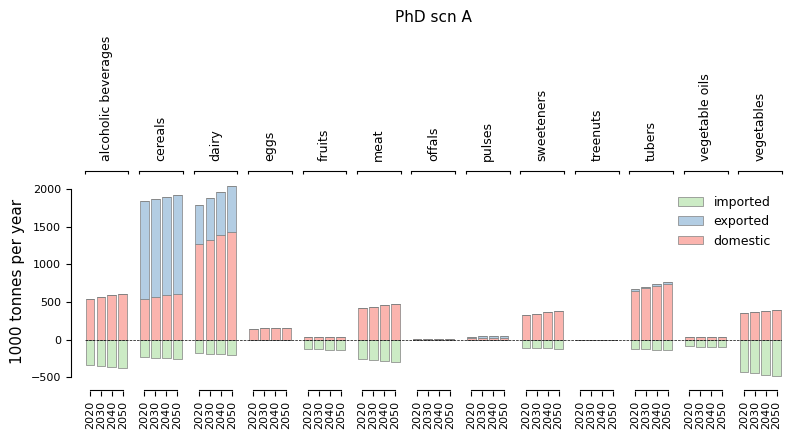

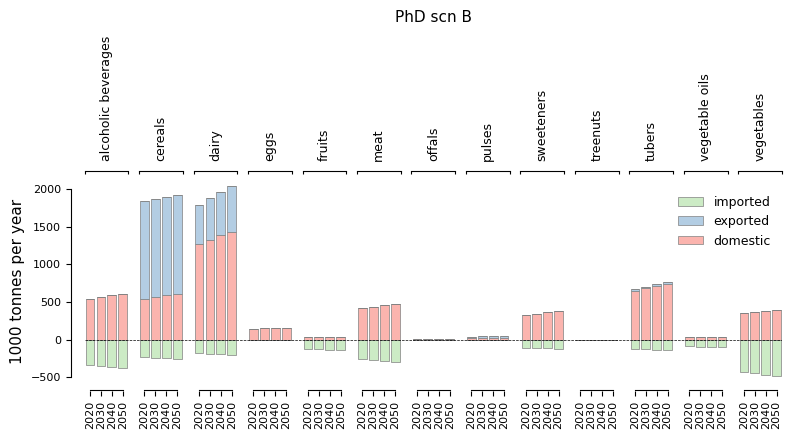

In [47]:
style = {
    'cmap' : 'Pastel1',
    'edgecolor' : 'grey',
    'bar_width' : 0.8,
    'group_spacing' : 1,
    'grouplabels_fontsize' : 9,
    'ticklabels_fontsize' : 8,
    'totmarker' : 'none',
    'ylabel' : '1000 tonnes per year'
}

plot_data = (
    session.get_attr(
        module='D',
        attr='food_demand_to_processing',
        groupby=['origin','food_group']
    ).add(
        session.get_attr(
            module='D',
            attr='export_demand',
            groupby=['origin','food_group']
        ).rename(columns={'domestic':'exported'}),
        fill_value = 0
    )
    .stack()
    .fillna(0)
)/1000000
plot_data.loc[:,'imported'] = -plot_data.loc[:,'imported']

for scn in ['PhD scn A', 'PhD scn B']:
    fig, ax = plt.subplots(figsize=(9,2.5))
    cm.plot.bar(
        plot_data.loc[scn],
        group_levels='food_group',
        grouplabels_vertical=True,
        grouptitle=scn,
        ax=ax,
        **style
    )
    plt.show()

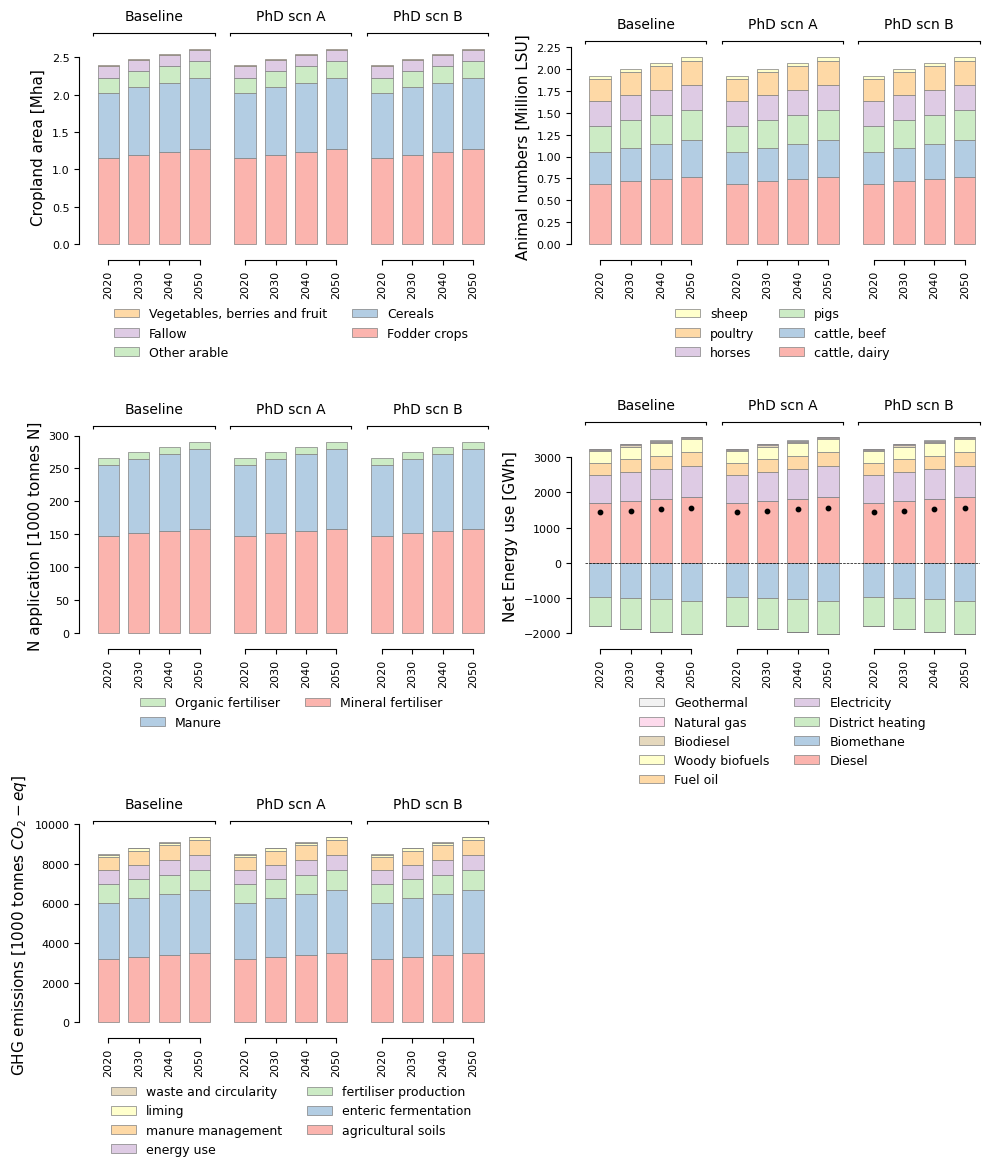

In [45]:
style = {
    'stacked' : True,
    'cmap' : 'Pastel1',
    'edgecolor' : 'grey',
    'ticklabels_fontsize' : 8,
    'bar_width' : 0.7
}

def _LSU(x):
    '''Gives livestock units (LSU) per head based on a tuple of (species, breed, animal)
    according to https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Livestock_unit_(LSU)'''
    sp,br,an = x
    if sp == 'cattle':
        if an == 'cows':
            if br == 'dairy':
                return 1
            else:
                return 0.8
        elif an == 'calves':
            return 0.4
        elif an == 'breeding bulls':
            return 1
        else:
            return 0.8
    elif sp == 'sheep':
        return 0.1
    elif sp == 'pigs':
        if an == 'piglets':
            return 0.027
        elif an == 'sows':
            return 0.5
        else:
            return 0.3
    elif sp == 'horses':
        return 0.8
    elif sp == 'poultry':
        if an == 'broilers':
            return 0.007
        else:
            return 0.014
    else:
        return np.nan

fig, axs = plt.subplots(3,2, figsize=(10,12))

# Cropland --->
ax = axs[0,0]
plot_data = session.get_attr('C','area',{'crop':'crop_group2'}, scn=['Baseline', 'PhD scn A', 'PhD scn B'])/1000000
plot.bar(
    plot_data.drop(['Semi-natural grasslands','Greenhouse crops'], axis=1),
    **style,
    ax=ax,
    sort_categories=True,
    group_levels='scn',
    ylabel='Cropland area [Mha]'
)

# Animals --->
ax = axs[0,1]
plot_data = session.get_attr('a','heads',['species','breed','animal'], scn=['Baseline', 'PhD scn A', 'PhD scn B'])
# Convert to LSU
plot_data = plot_data.mul([_LSU(x) for x in plot_data.columns], axis=1)
# Keep dairy/beef separate
idx = plot_data.columns.to_frame(index=False)
idx['species'] = idx['species'].where(idx['species'] != 'cattle',idx['species']+', '+idx['breed'])
plot_data.columns = pd.MultiIndex.from_frame(idx)
plot_data = plot_data.T.groupby('species').sum().T/1_000_000
plot.bar(
    plot_data,
    **style,
    ax=ax,
    sort_categories=True,
    group_levels='scn',
    ylabel='Animal numbers [Million LSU]'
)

# N application --->
ax = axs[1,0]
plot.bar(
    pd.concat([
        session.get_attr('C','fertiliser.mineral_N',{'crop':'land_use'}, scn=['Baseline', 'PhD scn A', 'PhD scn B']).loc[:,'cropland'].rename('Mineral fertiliser'),
        session.get_attr('C','fertiliser.manure_N',{'crop':'land_use'}, scn=['Baseline', 'PhD scn A', 'PhD scn B']).loc[:,'cropland'].rename('Manure'),
        session.get_attr('C','fertiliser.organic_N',{'crop':'land_use'}, scn=['Baseline', 'PhD scn A', 'PhD scn B']).loc[:,'cropland'].rename('Organic fertiliser'),
    ], axis=1)/1_000_000,
    **style,
    ax=ax,
    sort_categories=True,
    group_levels='scn',
    ylabel='N application [1000 tonnes N]'
)

# Net Energy use --->
ax = axs[1,1]
plot_data = (
    pd.concat([
        session.get_attr('C','energy_use','energy_source', scn=['Baseline', 'PhD scn A', 'PhD scn B']),
        session.get_attr('A','energy_use','energy_source', scn=['Baseline', 'PhD scn A', 'PhD scn B']),
        session.get_attr('W','energy_use', 'energy_source', scn=['Baseline', 'PhD scn A', 'PhD scn B']),
        -session.get_attr('W','energy_prod','energy_prod', scn=['Baseline', 'PhD scn A', 'PhD scn B']).rename_axis(columns='energy_source')
    ], axis=1)
    .T.groupby('energy_source').sum().T
)/1_000_000
plot.bar(
    plot_data,
    **style,
    ax=ax,
    sort_categories=True,
    group_levels='scn',
    ylabel='Net Energy use [GWh]'
)

# GHG emissions
ax = axs[2,0]
plot_data = (
    cm.get_GHG(session, scn=['Baseline', 'PhD scn A', 'PhD scn B'])
    .T.groupby('process').sum().T
)/1000000
plot.bar(
    plot_data,
    **style,
    ax=ax,
    sort_categories=True,
    group_levels='scn',
    ylabel=r'GHG emissions [1000 tonnes $CO_{2}-eq$]'
)

for ax in axs.flatten():
    if ax==axs.flatten()[-1]:
        ax.axis('off')
        continue
    ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.25), fontsize=9, frameon=False, reverse=True)

plt.tight_layout()
plt.show()

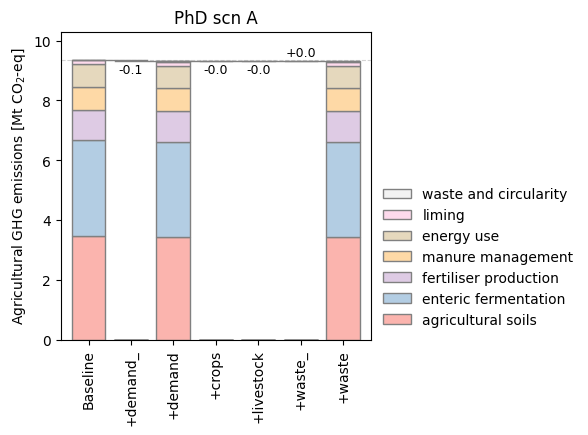

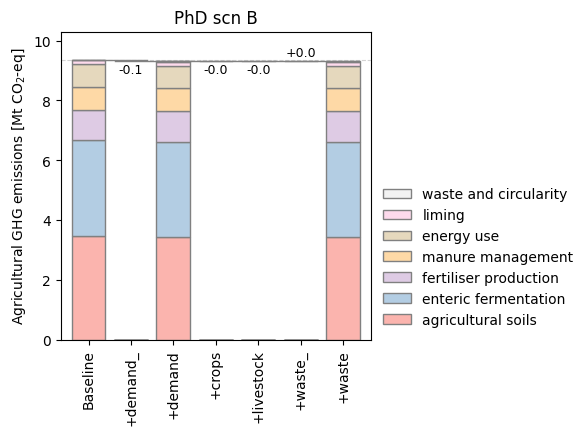

In [46]:
for id in ['A', 'B']:
    plot_data = (
        cm.get_GHG(session, scn=['Baseline',f'+demand {id}', f'+crops {id}', f'+livestock {id}', f'+waste {id}'], years='2050')
        .rename(index = lambda x: x.replace(f' {id}',''))
        .T.groupby('process').sum().T
        .droplevel('year')
    )/1_000_000_000
    
    # Sort
    s = plot_data.loc['Baseline'].sort_values(ascending=False).index

    fig, ax = plt.subplots(figsize=(4,4))
    
    plot.waterfall(
        data=plot_data.loc[:,s],
        ax=ax,
        breaks = ['+demand'],
        cmap='Pastel1',
        edgecolor='grey',
        width=0.8,
        label='absolute',
        label_size=9
    )
    
    ax.axhline(y=plot_data.sum(axis=1).loc['Baseline'], xmin=0, xmax=1, zorder=0, linestyle='--', linewidth=0.8, color='lightgrey')
    
    ax.tick_params(axis='y', which='major')
    ax.set_xlabel('')
    ax.set_title(f'PhD scn {id}')
    ax.set_ylabel('Agricultural GHG emissions [Mt CO$_2$-eq]')
    ax.set_ylim(top=plot_data.sum(axis=1).max()*1.1)
    ax.legend(loc='lower left', bbox_to_anchor=(1, 0), frameon=False, reverse=True)

    plt.show()